In [10]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from PIL import Image
import gc

## 1. Project Description

This project aims to leverage Generative Adversarial Networks (GANs), specifically a CycleGAN, to transform ordinary photographs into images that replicate the style of Claude Monet's paintings. The CycleGAN is designed to learn the translation between the domain of photographs and the domain of Monet paintings without requiring paired examples of photos and corresponding paintings.

### Monet Paintings Dataset:
- **Total Images**: 300
- **Image Dimensions**: 256x256 pixels
- **Color Mode**: RGB

### Photos Dataset:
- **Total Images**: 7,038
- **Image Dimensions**: 256x256 pixels
- **Color Mode**: RGB

In [11]:
# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:5]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:5]]

In [12]:
# Function to get dataset statistics
def get_dataset_stats(image_dir):
    image_count = 0
    dimensions = []
    color_modes = set()

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        with Image.open(img_path) as img:
            image_count += 1
            dimensions.append(img.size)  # (width, height)
            color_modes.add(img.mode)

    dimensions = np.array(dimensions)
    unique_dimensions = np.unique(dimensions, axis=0)

    print(f"Num of images: {image_count}")
    print(f"Unique dimensions: {unique_dimensions}")
    print(f"Color modes: {color_modes}")

print("Monet Paintings:")
monet_images_dir = './data/monet_jpg'
get_dataset_stats(monet_images_dir)

print("\nPhotos Dataset:")
photo_images_dir = './data/photo_jpg'
get_dataset_stats(photo_images_dir)

Monet Paintings:
Num of images: 300
Unique dimensions: [[256 256]]
Color modes: {'RGB'}

Photos Dataset:
Num of images: 7038
Unique dimensions: [[256 256]]
Color modes: {'RGB'}


## 2. Show Images

Monet Paintings:


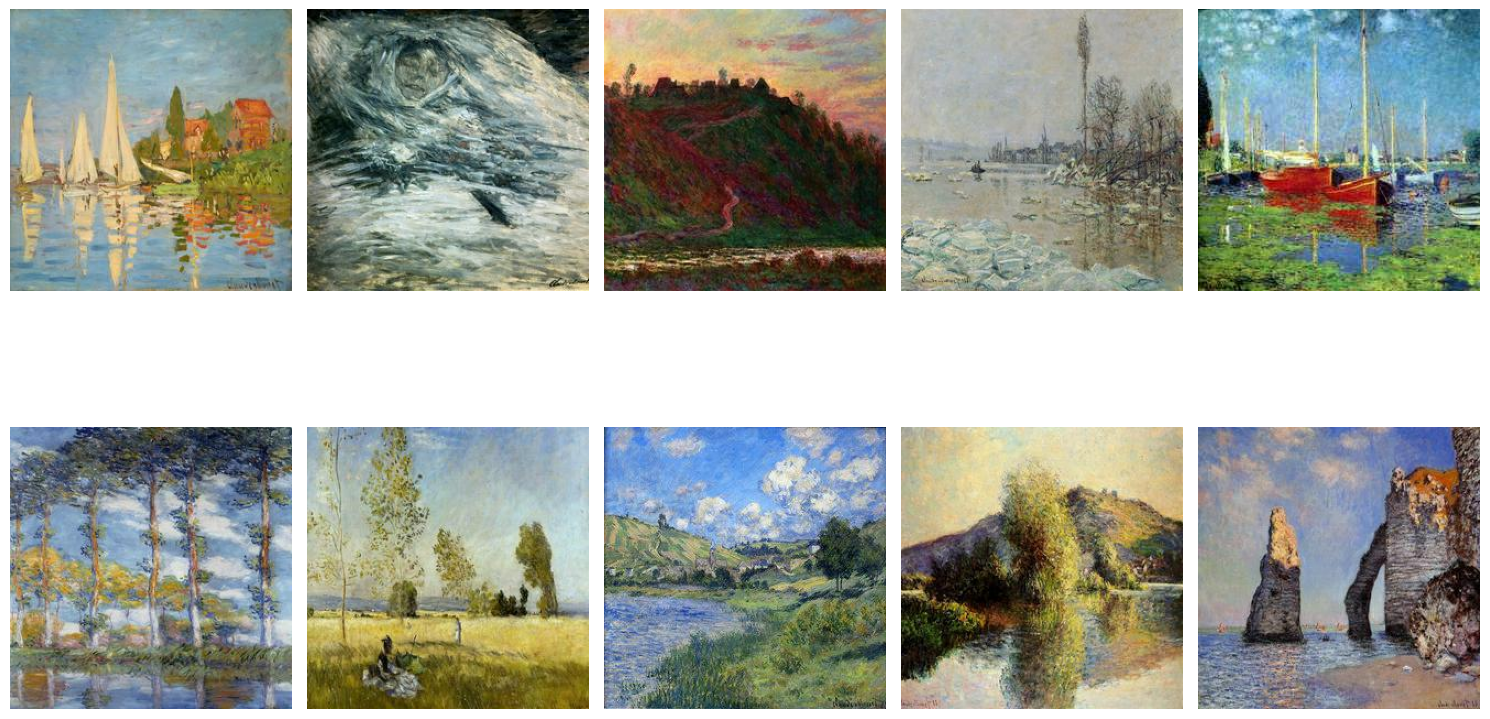

Photos:


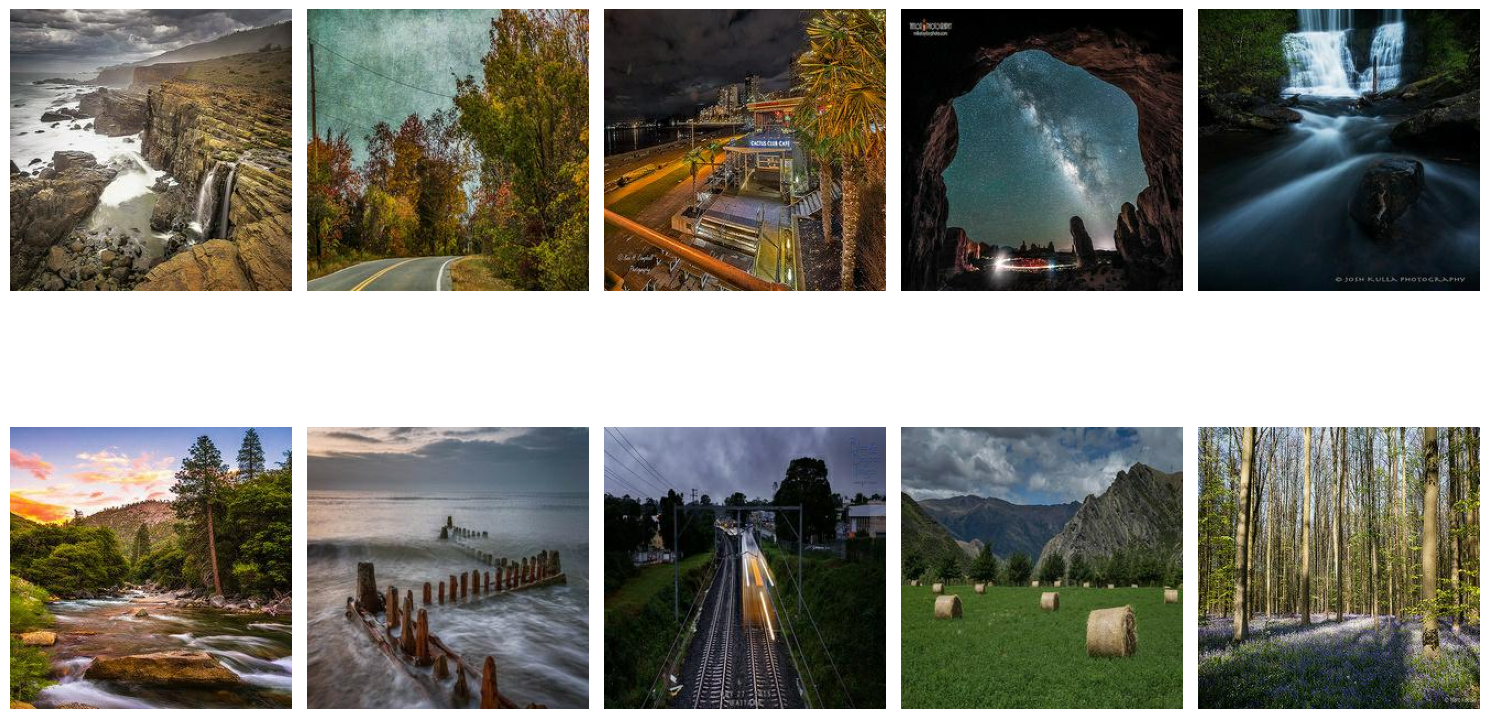

In [13]:
# Function to display a grid of images
def show_images(images, titles=None, cols=5, figsize=(15, 10)):
    assert (titles is None or len(images) == len(titles))
    n_images = len(images)
    cols = int(cols) 
    rows = np.ceil(n_images / float(cols)).astype(int)  
    fig = plt.figure(figsize=figsize)
    for n in range(n_images):
        ax = fig.add_subplot(rows, cols, n + 1)
        ax.imshow(images[n])
        if titles is not None:
            ax.set_title(titles[n])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load a few Monet paintings
monet_images_dir = './data/monet_jpg'
monet_images = [Image.open(os.path.join(monet_images_dir, img)) for img in os.listdir(monet_images_dir)[:10]]

# Load a few photos
photo_images_dir = './data/photo_jpg'
photo_images = [Image.open(os.path.join(photo_images_dir, img)) for img in os.listdir(photo_images_dir)[:10]]

# Display Monet paintings
print("Monet Paintings:")
show_images(monet_images)

# Display Photos
print("Photos:")
show_images(photo_images)

## 3. Model Architecture

### Comparison
#### 1. Pix2Pix
In the Pix2Pix model, there are three main components:
- **Generator (G)**: This model generates a new image based on a given input image. Unlike the standard GAN, where the generator produces an image from random noise, Pix2Pix's generator takes a specific input image and produces a corresponding output image (e.g., turning a sketch into a realistic image).
- **Discriminator (D)**: This model evaluates the generated image against the target image (the desired output for the given input). The discriminator's goal is to distinguish between the real target image and the generated image.
- **Conditional GAN**: Pix2Pix uses a conditional GAN framework, where the generator is conditioned on the input image. This means that the generator’s output depends directly on the input image, rather than generating an image purely from noise.

#### Key Features:
- **Paired Data Requirement**: Pix2Pix requires paired data, meaning that for every input image, there is a corresponding target image in the training dataset (e.g., a sketch and the corresponding photo).
- **L1 Loss**: In addition to the adversarial loss from the discriminator, Pix2Pix also uses an L1 loss between the generated image and the target image to encourage the generated output to be close to the target image.

### 2. CycleGAN
- **Two Generators**:
  - **Generator G**: Transforms images from domain X (e.g., photos) to domain Y (e.g., Monet-style paintings).
  - **Generator F**: Transforms images from domain Y (Monet-style paintings) back to domain X (photos).
- **Two Discriminators**:
  - **Discriminator D_X**: Tries to distinguish between real images from domain X and fake images generated by F.
  - **Discriminator D_Y**: Tries to distinguish between real images from domain Y and fake images generated by G.
- **Cycle Consistency Loss**:
  - Ensures that if you transform an image to the other domain and back again, you should retrieve the original image.
- **Identity Loss (Optional but often used)**: Ensures that if you input an image from one domain into the generator corresponding to that domain, it should produce the same image.

### Summary
The code I've been working on implements a CycleGAN, which is a specific type of GAN designed for unpaired image-to-image translation. Unlike Pix2Pix, which requires paired data and is focused on generating a corresponding image from a given input, CycleGAN is aimed at transforming images between two domains without the need for paired data (e.g., converting photos into Monet-style paintings and vice versa).

### 1. Define

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Generator
class SimpleGenerator(nn.Module):
    def __init__(self, num_layers=6):
        super(SimpleGenerator, self).__init__()
        self.num_layers = num_layers
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Downsampling layers
        self.down_sampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
            
        # Residual blocks
        res_blocks = []
        for _ in range(num_layers):
            res_blocks += [ResidualBlock(256)]
        self.res_blocks = nn.Sequential(*res_blocks)
            
        # Upsampling layers
        self.up_sampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.output = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down_sampling(x)
        x = self.res_blocks(x)
        x = self.up_sampling(x)
        return self.output(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.instance_norm(self.conv1(x)))
        out = self.instance_norm(self.conv2(out))
        out += residual
        return self.relu(out)

# Discriminator
class SimpleDiscriminator(nn.Module):
    def __init__(self, num_layers=4):
        super(SimpleDiscriminator, self).__init__()
        self.num_layers = num_layers
        
        model = [
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        current_dim = 64
        for _ in range(1, num_layers):  # The first layer is already added
            new_dim = min(current_dim * 2, 512)
            model += [
                nn.Conv2d(current_dim, new_dim, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(new_dim),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            current_dim = new_dim

        model += [nn.Conv2d(current_dim, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

### 2. Data Preparation
Including Image Augmentation

In [15]:
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(0.5),            
            transforms.RandomRotation(10),              
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
            transforms.ToTensor(),                      
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   
        ])

    def __call__(self, img):
        img = self.transforms(img)
        return img

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('jpg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                        ])(image)
        return image

def get_data_loaders(monet_dir, photo_dir, batch_size, stage='fit'):
    batch_size = max(1, int(batch_size))

    monet_dataset = CustomImageDataset(monet_dir, transform=CustomTransform())
    monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

    if stage == "fit":
        photo_dataset = CustomImageDataset(photo_dir, transform=CustomTransform())
    elif stage in ["test", "predict"]:
        photo_dataset = CustomImageDataset(photo_dir)

    photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)
    
    return monet_loader, photo_loader

### 3. Initial Training

In [16]:
def train(generator, discriminator, monet_loader, photo_loader, num_epochs, device, lr=0.0002):
    criterion = nn.MSELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for i, (monet_imgs, photo_imgs) in enumerate(zip(monet_loader, photo_loader)):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            fake_monet = generator(real_photo)
            d_loss_real = criterion(discriminator(real_monet), torch.ones_like(discriminator(real_monet)))
            d_loss_fake = criterion(discriminator(fake_monet.detach()), torch.zeros_like(discriminator(fake_monet)))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_monet), torch.ones_like(discriminator(fake_monet)))
            g_loss.backward()
            optimizer_G.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'generator_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'discriminator_epoch_{epoch+1}.pth'))
    
    return generator, discriminator


## 4. Results and Analysis


### 1. Hyperparameter Tuning

In [17]:
from tqdm import tqdm
from scipy import linalg
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

space = [
    Real(1e-5, 1e-3, name='learning_rate', prior='log-uniform'),
    Integer(2, 10, name='batch_size'),
    Integer(3, 5, name='generator_layers'),
    Integer(3, 5, name='discriminator_layers')
]

@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    generator_layers = params['generator_layers']
    discriminator_layers = params['discriminator_layers']

    generator = SimpleGenerator(num_layers=generator_layers).to(device)
    discriminator = SimpleDiscriminator(num_layers=discriminator_layers).to(device)

    monet_loader, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=batch_size)

    generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=5, device=device, lr=learning_rate)

    
    score = evaluate_model(generator, discriminator, monet_loader, photo_loader, device)

    return score

# Hyperparameter tuning function using Bayesian optimization
def hyperparameter_tuning(device):
    result = gp_minimize(objective, space, n_calls=50, random_state=42, verbose=True)
    
    best_params = {
        'learning_rate': result.x[0],
        'batch_size': result.x[1],
        'generator_layers': result.x[2],
        'discriminator_layers': result.x[3]
    }
    
    return best_params

# Evaluation function for hyperparameter tuning
def evaluate_model(generator, discriminator, monet_loader, photo_loader, device):
    generator.eval()
    discriminator.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for monet_imgs, photo_imgs in zip(monet_loader, photo_loader):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)

            fake_monet = generator(real_photo)
            fake_score = discriminator(fake_monet)
            real_score = discriminator(real_monet)

            loss = ((fake_score - 1) ** 2).mean() + ((real_score - 1) ** 2).mean()
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

In [18]:
output_dir = 'model'
os.makedirs(output_dir, exist_ok=True)

# Hyperparameter tuning
print("Starting hyperparameter tuning...")
best_params = hyperparameter_tuning(device)
print(f"Best hyperparameters: {best_params}")

Starting hyperparameter tuning...
Iteration No: 1 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2698, G_loss: 0.3275
Epoch [2/5], D_loss: 0.3755, G_loss: 0.2037
Epoch [3/5], D_loss: 0.3321, G_loss: 0.3486
Epoch [4/5], D_loss: 0.3664, G_loss: 0.3593
Epoch [5/5], D_loss: 0.2887, G_loss: 0.4148
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 151.0068
Function value obtained: 0.6329
Current minimum: 0.6329
Iteration No: 2 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2481, G_loss: 0.4812
Epoch [2/5], D_loss: 0.2943, G_loss: 0.2579
Epoch [3/5], D_loss: 0.2658, G_loss: 0.3760
Epoch [4/5], D_loss: 0.2800, G_loss: 0.3081
Epoch [5/5], D_loss: 0.2339, G_loss: 0.3697
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 137.7620
Function value obtained: 0.6087
Current minimum: 0.6087
Iteration No: 3 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2449, G_loss: 0.4920
Epoch [2/5], D_loss: 0.2567, G

In [ ]:
# Reinitialize data loaders with best batch size
monet_loader, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=best_params['batch_size'])

# Initialize models with best hyperparameters
generator = SimpleGenerator(num_layers=best_params['generator_layers']).to(device)
discriminator = SimpleDiscriminator(num_layers=best_params['discriminator_layers']).to(device)

# Initial training with best hyperparameters
print("Starting initial training ...")
generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=100, device=device, lr=best_params['learning_rate'])

Best hyperparameters: {'learning_rate': 0.00016722697006183674, 'batch_size': 2, 'generator_layers': 4, 'discriminator_layers': 5}
Starting initial training with best hyperparameters...
Epoch [1/100], D_loss: 0.3643, G_loss: 0.6817
Epoch [2/100], D_loss: 0.1775, G_loss: 0.3660
Epoch [3/100], D_loss: 0.3197, G_loss: 0.3988
Epoch [4/100], D_loss: 0.3567, G_loss: 0.3927
Epoch [5/100], D_loss: 0.2537, G_loss: 1.1693
Epoch [6/100], D_loss: 0.1314, G_loss: 0.7896
Epoch [7/100], D_loss: 0.2533, G_loss: 0.8390
Epoch [8/100], D_loss: 0.5121, G_loss: 0.4243
Epoch [9/100], D_loss: 0.0670, G_loss: 0.9111
Epoch [10/100], D_loss: 0.0877, G_loss: 0.8548
Epoch [11/100], D_loss: 0.1045, G_loss: 1.1122
Epoch [12/100], D_loss: 0.2479, G_loss: 0.4244
Epoch [13/100], D_loss: 0.3430, G_loss: 0.2197
Epoch [14/100], D_loss: 0.2693, G_loss: 1.0356
Epoch [15/100], D_loss: 0.2379, G_loss: 0.4638
Epoch [16/100], D_loss: 0.1237, G_loss: 0.8912
Epoch [17/100], D_loss: 0.1690, G_loss: 1.0074
Epoch [18/100], D_loss: 

### 2. Fine-tuning

In [ ]:
def fine_tune(generator, discriminator, monet_loader, photo_loader, num_epochs, device, best_params):
    lr = best_params['learning_rate'] * 0.1 

    batch_size = best_params['batch_size']

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer setup using the fine-tuned learning rate
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, (monet_imgs, photo_imgs) in enumerate(zip(monet_loader, photo_loader)):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)
    
            # Ensure the batch sizes match
            current_batch_size = min(real_monet.size(0), real_photo.size(0))
            real_monet = real_monet[:current_batch_size]
            real_photo = real_photo[:current_batch_size]

            # Fine-tune Discriminator
            optimizer_D.zero_grad()
            fake_monet = generator(real_photo)
            d_loss_real = criterion(discriminator(real_monet), torch.ones_like(discriminator(real_monet)))
            d_loss_fake = criterion(discriminator(fake_monet.detach()), torch.zeros_like(discriminator(fake_monet)))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # Fine-tune Generator
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_monet), torch.ones_like(discriminator(fake_monet)))
            g_loss.backward()
            optimizer_G.step()
            
        print(f"Fine-tuning Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        if (epoch + 1) % 5 == 0:
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'generator_finetuned_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'discriminator_finetuned_epoch_{epoch+1}.pth'))
           
    return generator, discriminator


In [ ]:
# Fine-tuning
print("Starting fine-tuning...")
generator, discriminator = fine_tune(generator, discriminator, monet_loader, photo_loader, num_epochs=50, device=device, best_params=best_params)

Starting fine-tuning...
Fine-tuning Epoch [1/50], D_loss: 0.1976, G_loss: 0.4733
Fine-tuning Epoch [2/50], D_loss: 0.1033, G_loss: 0.6475
Fine-tuning Epoch [3/50], D_loss: 0.1668, G_loss: 0.4776
Fine-tuning Epoch [4/50], D_loss: 0.0242, G_loss: 0.7244
Fine-tuning Epoch [5/50], D_loss: 0.0839, G_loss: 0.6151
Fine-tuning Epoch [6/50], D_loss: 0.2029, G_loss: 0.4109
Fine-tuning Epoch [7/50], D_loss: 0.0532, G_loss: 0.6106
Fine-tuning Epoch [8/50], D_loss: 0.1294, G_loss: 0.6440
Fine-tuning Epoch [9/50], D_loss: 0.2905, G_loss: 0.4105
Fine-tuning Epoch [10/50], D_loss: 0.0509, G_loss: 0.6036
Fine-tuning Epoch [11/50], D_loss: 0.0237, G_loss: 0.7990
Fine-tuning Epoch [12/50], D_loss: 0.1882, G_loss: 0.3972
Fine-tuning Epoch [13/50], D_loss: 0.1379, G_loss: 0.8987
Fine-tuning Epoch [14/50], D_loss: 0.0645, G_loss: 0.7499
Fine-tuning Epoch [15/50], D_loss: 0.1141, G_loss: 0.7889
Fine-tuning Epoch [16/50], D_loss: 0.0131, G_loss: 1.2153
Fine-tuning Epoch [17/50], D_loss: 0.0813, G_loss: 0.5571

In [ ]:
def generate_and_save_images(generator, photo_loader, num_images, output_dir, device):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'generated'), exist_ok=True)

    generator.eval()

    with torch.no_grad():
        for i, (batch_images, _) in tqdm(enumerate(photo_loader), total=num_images):
            if i >= num_images:
                break
            batch_images = batch_images.to(device)
            fake_images = generator(batch_images)

            # Save original images
            save_image(batch_images, os.path.join(output_dir, 'original', f'original_{i}.jpg'), normalize=True)

            # Save generated images
            save_image(fake_images, os.path.join(output_dir, 'generated', f'generated_{i}.jpg'), normalize=True)

def create_comparison_plot(output_dir, num_samples=5):
    original_dir = os.path.join(output_dir, 'original')
    generated_dir = os.path.join(output_dir, 'generated')

    original_images = sorted(os.listdir(original_dir))[:num_samples]
    generated_images = sorted(os.listdir(generated_dir))[:num_samples]

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    fig.suptitle("Original vs Generated Images", fontsize=16)

    for i in range(num_samples):
        # Original image
        img_orig = plt.imread(os.path.join(original_dir, original_images[i]))
        axes[i, 0].imshow(img_orig)
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Generated image
        img_gen = plt.imread(os.path.join(generated_dir, generated_images[i]))
        axes[i, 1].imshow(img_gen)
        axes[i, 1].set_title(f"Generated {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'comparison_plot.png'))
    # plt.close()

### 4. Generate Images

100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


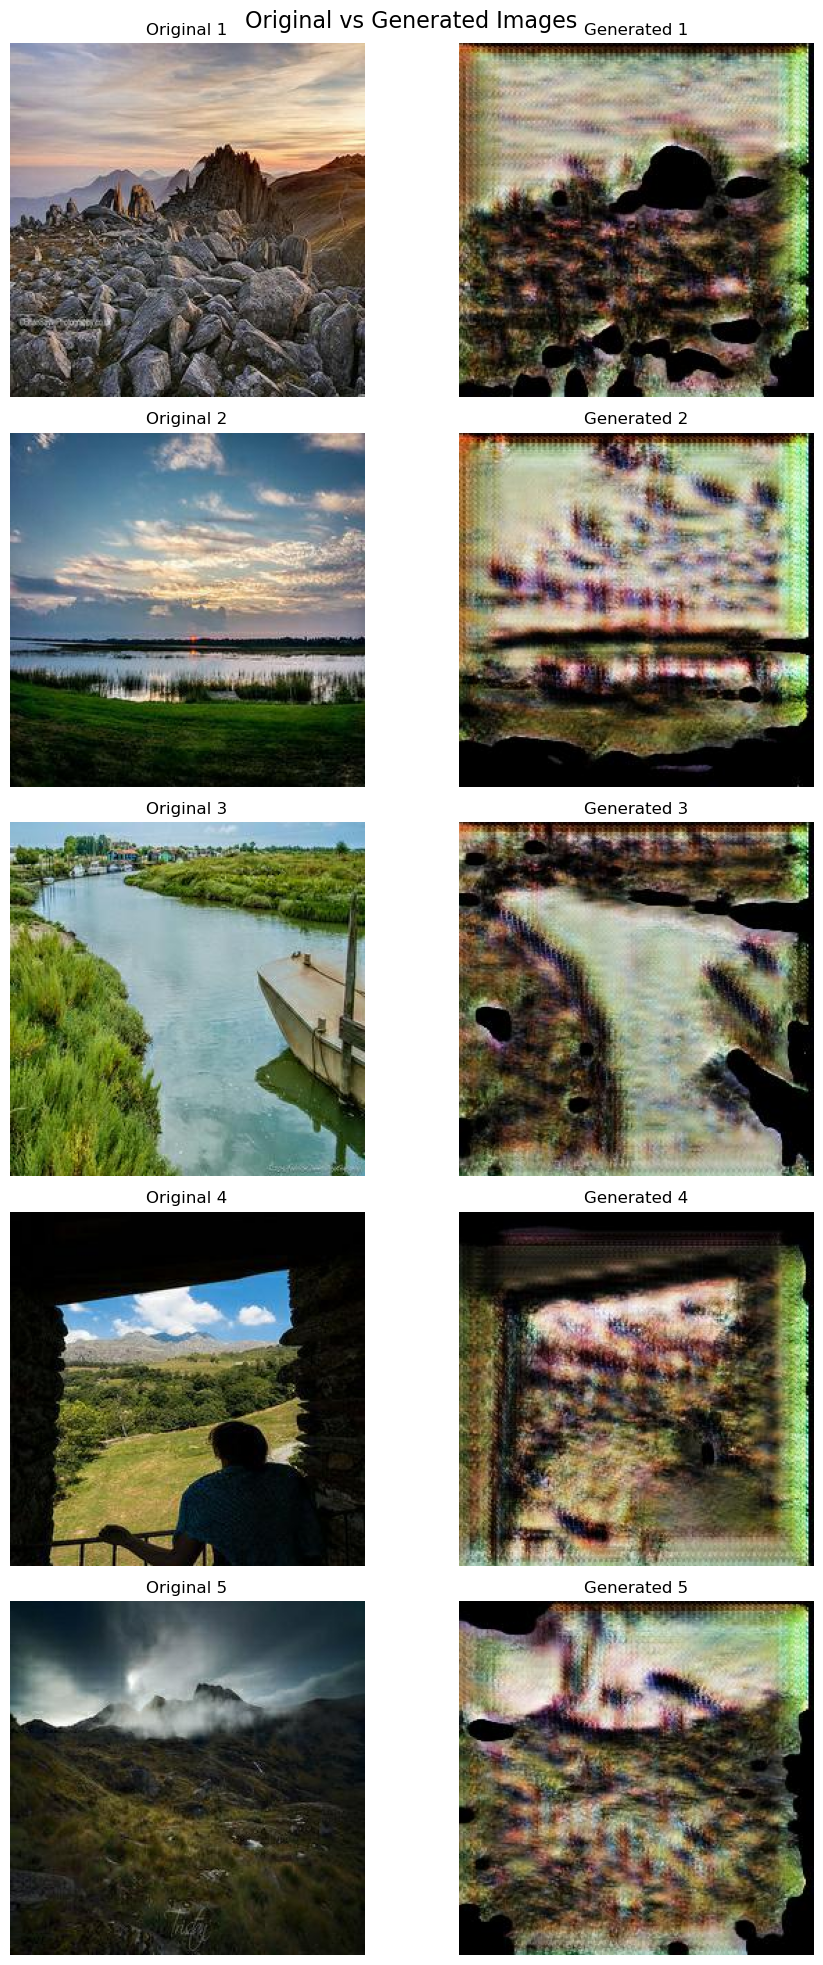

In [ ]:
_, photo_loader = get_data_loaders('./data/monet_jpg/', './data/photo_jpg/', batch_size=best_params['batch_size'], stage='test')
generate_and_save_images(generator, photo_loader, num_images=10, output_dir='output', device=device)
create_comparison_plot(output_dir='output', num_samples=5)

In [ ]:
def load_pretrained_generator(model_path, device):
    generator = SimpleGenerator().to(device)
    
    # Load the state dict with strict=False to handle potential mismatched keys
    state_dict = torch.load(model_path, map_location=device)
    generator.load_state_dict(state_dict, strict=False)
    
    generator.eval()
    return generator

# generator = load_pretrained_generator('./output/generator_epoch_70.pth', device)

## 5. Conclusion

### 1. Strengths:

- **Comprehensive Approach**: The project thoroughly covers all critical steps, from data preparation to model evaluation, ensuring a well-rounded implementation.
- **Hyperparameter Tuning**: Utilizes Bayesian optimization to efficiently identify optimal hyperparameters, enhancing model performance.
- **Data Augmentation**: Employs various image augmentation techniques to improve model generalization and robustness.

### 2. Areas for Improvement:

- **Model Complexity**: The current generator and discriminator architectures are relatively simple. Consider adopting more advanced architectures, such as ResNet-based models, to potentially improve performance.
- **Training Stability**: GANs are prone to instability during training. Implementing techniques like gradient penalty or spectral normalization could enhance training stability and consistency.
- **Evaluation Metrics**: Incorporates MiFID to improve evaluation metrics. Consider additional metrics like FID or SSIM for a more comprehensive evaluation.


In [ ]:
import zipfile
import io

def generate_and_zip_images(generator, photo_loader, num_images, zip_filename, device):
    generator.eval()

    to_pil = transforms.ToPILImage()

    with zipfile.ZipFile(zip_filename, 'w') as zf:
        image_count = 0
        with torch.no_grad():
            for batch in tqdm(photo_loader, desc="Generating images"):
                batch = batch.to(device)
                generated_images = generator(batch)

                for img in generated_images:
                    if image_count >= num_images:
                        return

                    img_pil = to_pil(img.cpu().clamp(-1, 1) * 0.5 + 0.5)
                    img_pil = img_pil.resize((256, 256), Image.LANCZOS)

                    img_byte_arr = io.BytesIO()
                    img_pil.save(img_byte_arr, format='JPEG', quality=95)
                    img_byte_arr = img_byte_arr.getvalue()

                    zf.writestr(f'monet_{image_count:05d}.jpg', img_byte_arr)

                    image_count += 1
                    if image_count >= num_images:
                        return